In [1]:
!pip install anndata
!pip install scanpy
!pip install igraph
!pip install louvain
!pip3 install leidenalg
# !pip install gprofiler-official
# !pip install scvi-tools[cpu]==1.1.2
# !pip install --quiet magic-impute

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971834 sha256=22e9056c169e22c175b54866bc65ff707f663f100c4d54dd43b1a494c4d73232
  Stored in directory: /root/.cache/pip/wheels/40/de/2b/bb7ed19d84727f9f299f20cd34c42bba9c8bef7d83d2255c86
Successfully built louvain
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Preprocessing

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


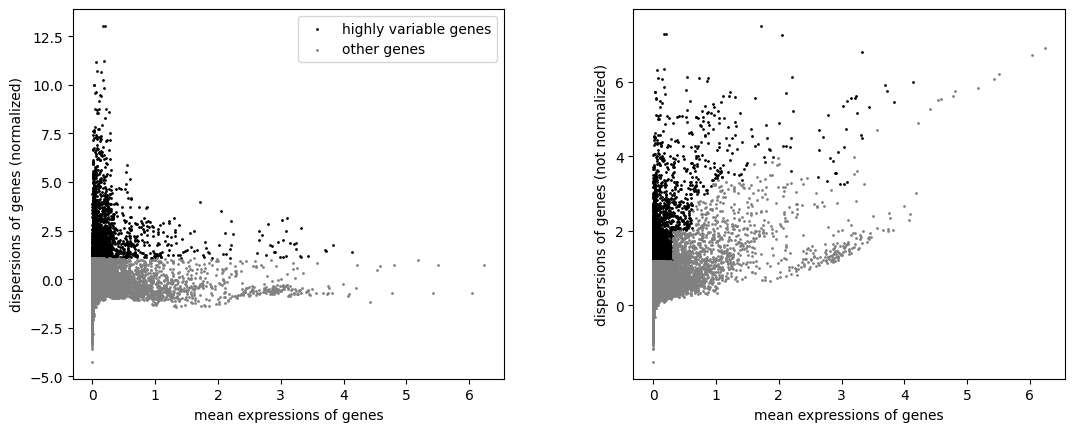

In [2]:
import scanpy as sc
import anndata
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score
import pandas as pd

adata = sc.read_h5ad("cleaned_processed_frogtail.h5ad")
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata,base=2)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
sc.pl.highly_variable_genes(adata)

Clustering

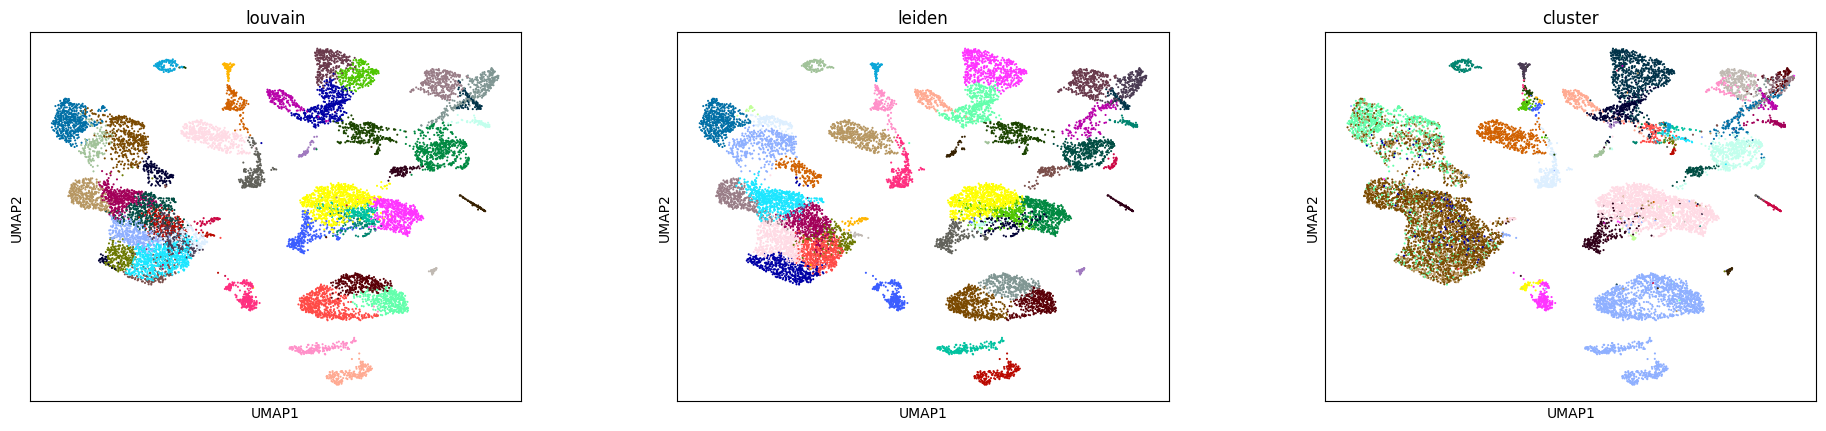

              ARI  Rand Index  Silhouette  Calinski-Harabasz Score
louvain  0.305654    0.913969    0.197730              1880.197388
leiden   0.323023    0.915172    0.205604              1866.762329


In [ ]:
sc.tl.pca(adata, svd_solver='arpack') #PCA

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.louvain(adata, key_added="louvain",resolution=2.49) #Louvain
sc.tl.leiden(adata, key_added="leiden",resolution=1.8) #Leiden

sc.tl.umap(adata)
sc.pl.umap(adata, color=["louvain", "leiden",'cluster'], wspace=0.2,legend_loc=None)

true_labels = LabelEncoder().fit_transform(adata.obs["cluster"].astype(str))
results = {}
for method in ["louvain", "leiden"]:
    pred_labels = adata.obs[method].astype(str)
    ari = adjusted_rand_score(true_labels, pred_labels)
    ri = rand_score(true_labels, pred_labels)
    sil = silhouette_score(adata.obsm["X_pca"], pred_labels)
    ch_score = calinski_harabasz_score(adata.obsm["X_pca"], pred_labels,)
    results[method] = {"ARI": ari, "Rand Index": ri, "Silhouette": sil,"Calinski-Harabasz Score":ch_score}

df = pd.DataFrame(results).T
print(df)

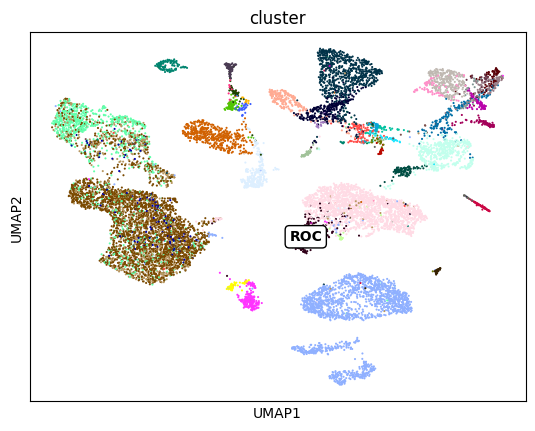

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sc.pl.umap(adata, color='cluster', show=False,legend_loc='none')

umap = adata.obsm['X_umap']
x = umap[adata.obs['cluster'] == 'ROCs', 0]
y = umap[adata.obs['cluster'] == 'ROCs', 1]
x_mean, y_mean = np.median(x), np.median(y)
plt.text(
    x_mean, y_mean, 'ROC',
    fontsize=10, color='black', weight='bold',
    ha='center', va='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

plt.show()

Marker selection

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    groupby="cluster",
    method="logreg",
    key_added="rank_genes_logistic"
)

sc.tl.rank_genes_groups(
    adata,
    groupby="cluster",
    method="wilcoxon",
    key_added="rank_genes_wilcoxon"
)

markers_logistics = list(sc.get.rank_genes_groups_df(adata, group='ROCs', key="rank_genes_logistic").head(50)['names'])
markers_wilcoxon = list(sc.get.rank_genes_groups_df(adata, group='ROCs', key="rank_genes_wilcoxon").head(50)['names'])

print(markers_logistics)
print(markers_wilcoxon)

overlap = set(markers_logistics) & set(markers_wilcoxon)
print(overlap,len(overlap))

lst = [
    'wnt5a','loc100488523','loc100492954','egfl6','lpar3','cpa6','sp9','fgf9',
    'fbn2','tinagl1','fgf7','vwde','lef1','lamb2','fgfr4','fgf7','rspo2','cpa6',
    'loc100498358','krt','loc100486832','jag1','Xelaev18043128m','dlx2','tp73',
    'gdf6','Xelaev18046800m','nid2','igfbp2','ism2','dlx2','loc100493805','frem2',
    'Xelaev18044182m','bmp5','tspear','sema3f','robo4','jchain','rspo2','adamts18',
    'pltp','Xelaev18034799m','lamb1','lamb1','unc5b','mmp28','fgf10','pzp','galnt15'
]
#markers_logistics,markers_wilcoxon = [i.split('.')[0] if '.' in i else i for i in markers_logistics],[i.split('.')[0] if '.' in i else i for i in markers_wilcoxon]
overlap_logistic,overlap_wilcoxon = set(lst) & set([i.split('.')[0] if '.' in i else i for i in markers_logistics]),set(lst) & set([i.split('.')[0] if '.' in i else i for i in markers_wilcoxon])
print(overlap_logistic,len(overlap_logistic))
print(overlap_wilcoxon,len(overlap_wilcoxon))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_

['apoc1.like.L', 'pltp.S', 'fn1.S', 'Xetrov90029035m.L', 'id3.L', 'frem2.1.L', 'nid2.L', 'loc100486548.L', 'fstl1.L', 'krt16.S', 'col14a1.S', 'sp9.L', 'loc100127750.S', 'ptgs1.S', 'krt5.7.S', 'lama5.L', 'fras1.L', 'hbd.L', 'mdk.L', 'egfl6.L', 'col14a1.L', 'Xelaev18045099m.g', 'id3.S', 'krt16.L', 'azin2.S', 'loc100490088.S', 'bmp4.S', 'Xelaev18045098m.g', 'sparc.S', 'plk2.S', 'lpar3.L', 'net1.L', 'krt12.L', 'lama1.L', 'mdk.S', 'app.S', 'Xelaev18045083m.g', 'bambi.L', 'loc100486548.S', 'ctsv.S', 'ifitm3.S', 'krt8.L', 'hbd.S', 'cpamd8.L', 'cldn6.1.S', 'tmsb4x.L', 'vwde.L', 'unc5b.L', 'optc.S', 'sparc.L']
['col14a1.S', 'apoc1.like.L', 'loc100486548.L', 'mdk.L', 'id3.S', 'lama5.L', 'fras1.L', 'col14a1.L', 'id3.L', 'bambi.L', 'frem2.1.L', 'egfl6.S', 'fn1.S', 'azin2.S', 'msx2.L', 'plk2.S', 'myh9.S', 'mmp3.L', 'cpamd8.L', 'mdk.S', 'frem2.L', 'krt5.7.S', 'nid2.L', 'bambi.S', 'epcam.L', 'btg1.L', 'Xelaev18026267m.g', 'Xetrov90029035m.L', 'cldn6.2.S', 'fstl1.L', 'Xelaev18017960m.g', 'krt8.L', 'la

In [ ]:
list(sc.get.rank_genes_groups_df(adata, group='ROCs', key="rank_genes_logistic").head(5)['names'])

['apoc1.like.L', 'pltp.S', 'fn1.S', 'Xetrov90029035m.L', 'id3.L']

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 26166 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


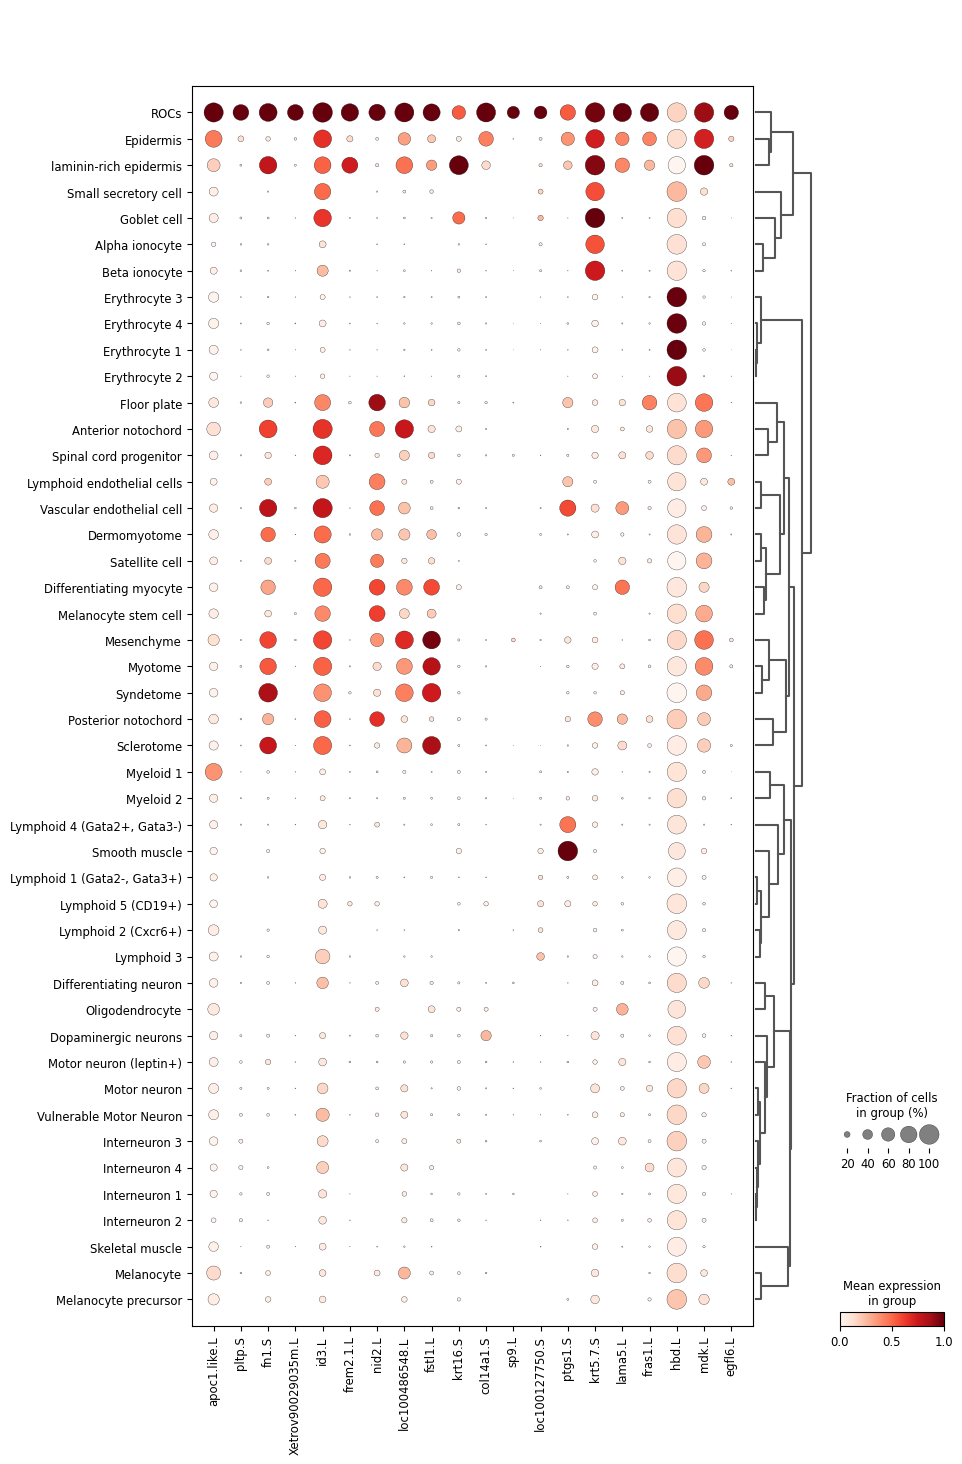

In [ ]:
markers = [g for g in markers_logistics if g in adata.var_names] #markers_wilcoxon
sc.pl.dotplot(
    adata,
    var_names=markers[:20],
    groupby="cluster",
    standard_scale="var",
    dendrogram=True
)


In [ ]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
results = gp.profile(
    organism="hsapiens",
    query=[i.split('.')[0] for i in markers_logistics],
    sources=["GO:BP", "GO:MF", "GO:CC"]
)

sig = results[results['significant']].sort_values("p_value").head(10)
print(sig[["native", "name", "p_value", "term_size", "intersection_size"]])


       native                                         name       p_value  \
0  GO:0005604                            basement membrane  4.299451e-10   
1  GO:0005576                         extracellular region  1.673416e-08   
2  GO:0031012                         extracellular matrix  1.792940e-07   
3  GO:0030312             external encapsulating structure  1.826935e-07   
4  GO:0005201  extracellular matrix structural constituent  1.860277e-07   
5  GO:0005615                          extracellular space  5.583627e-07   
6  GO:0062023     collagen-containing extracellular matrix  2.358223e-06   
7  GO:0005198                 structural molecule activity  1.058271e-05   
8  GO:0009653           anatomical structure morphogenesis  1.134959e-05   
9  GO:0048870                                cell motility  1.005792e-04   

   term_size  intersection_size  
0         93                  8  
1       4258                 25  
2        559                 11  
3        560               

In [ ]:
# !pip install scvi-tools[cpu]==1.1.2
# !pip install --quiet magic-impute

Denoising

In [ ]:
import scvi
adata_scvi = adata.copy()
scvi.model.SCVI.setup_anndata(adata_scvi)
model = scvi.model.SCVI(adata_scvi)
model.train(max_epochs=100)
adata_scvi.X = model.get_normalized_expression(library_size=1e4)
print(adata.X.shape, adata_scvi.X.shape)
adata_scvi.write("adata_denoised_scvi.h5ad")

/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/usr/local/lib/python3.12/dist-packages/anndata/experimental/__init__.py:48: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  return module_get_attr_redirect(
/usr/local/lib/python3.12/dist-packages/ann

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [01:42<2:48:25, 102.07s/it, v_num=1, train_loss_step=5.1e+3, train_loss_epoch=5.98e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/100:   2%|▏         | 2/100 [03:20<2:43:33, 100.13s/it, v_num=1, train_loss_step=5.08e+3, train_loss_epoch=5.03e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/100:   3%|▎         | 3/100 [04:59<2:40:31, 99.29s/it, v_num=1, train_loss_step=4.58e+3, train_loss_epoch=4.91e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/100:   4%|▍         | 4/100 [06:36<2:37:43, 98.58s/it, v_num=1, train_loss_step=4.91e+3, train_loss_epoch=4.84e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [08:14<2:35:35, 98.27s/it, v_num=1, train_loss_step=4.61e+3, train_loss_epoch=4.78e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/100:   6%|▌         | 6/100 [09:53<2:34:13, 98.44s/it, v_num=1, train_loss_step=4.8e+3, train_loss_epoch=4.74e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/100:   7%|▋         | 7/100 [11:35<2:34:40, 99.79s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.7e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/100:   8%|▊         | 8/100 [13:13<2:31:58, 99.11s/it, v_num=1, train_loss_step=4.74e+3, train_loss_epoch=4.67e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/100:   9%|▉         | 9/100 [14:51<2:29:54, 98.84s/it, v_num=1, train_loss_step=4.59e+3, train_loss_epoch=4.64e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/100:  10%|█         | 10/100 [16:28<2:27:19, 98.22s/it, v_num=1, train_loss_step=4.5e+3, train_loss_epoch=4.61e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/100:  11%|█         | 11/100 [18:05<2:25:19, 97.98s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.59e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/100:  12%|█▏        | 12/100 [19:47<2:25:26, 99.16s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.57e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/100:  13%|█▎        | 13/100 [21:24<2:22:51, 98.52s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.55e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/100:  14%|█▍        | 14/100 [23:03<2:21:21, 98.63s/it, v_num=1, train_loss_step=4.62e+3, train_loss_epoch=4.53e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/100:  15%|█▌        | 15/100 [24:43<2:20:06, 98.90s/it, v_num=1, train_loss_step=4.74e+3, train_loss_epoch=4.51e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/100:  16%|█▌        | 16/100 [26:21<2:18:01, 98.59s/it, v_num=1, train_loss_step=4.58e+3, train_loss_epoch=4.49e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/100:  17%|█▋        | 17/100 [28:02<2:17:45, 99.58s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.48e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/100:  18%|█▊        | 18/100 [29:39<2:14:48, 98.64s/it, v_num=1, train_loss_step=4.11e+3, train_loss_epoch=4.46e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/100:  19%|█▉        | 19/100 [31:15<2:12:10, 97.91s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.45e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/100:  20%|██        | 20/100 [32:51<2:09:46, 97.33s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.44e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/100:  21%|██        | 21/100 [34:29<2:08:33, 97.64s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.43e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/100:  22%|██▏       | 22/100 [36:07<2:06:53, 97.61s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.42e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/100:  23%|██▎       | 23/100 [37:44<2:04:51, 97.29s/it, v_num=1, train_loss_step=4.39e+3, train_loss_epoch=4.4e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/100:  24%|██▍       | 24/100 [39:21<2:03:09, 97.23s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.39e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/100:  25%|██▌       | 25/100 [40:59<2:01:50, 97.47s/it, v_num=1, train_loss_step=4.4e+3, train_loss_epoch=4.39e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/100:  26%|██▌       | 26/100 [42:37<2:00:39, 97.83s/it, v_num=1, train_loss_step=4.42e+3, train_loss_epoch=4.38e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/100:  27%|██▋       | 27/100 [44:17<1:59:35, 98.30s/it, v_num=1, train_loss_step=4.54e+3, train_loss_epoch=4.37e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/100:  28%|██▊       | 28/100 [45:52<1:57:02, 97.54s/it, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4.36e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/100:  29%|██▉       | 29/100 [47:31<1:55:42, 97.78s/it, v_num=1, train_loss_step=4.34e+3, train_loss_epoch=4.35e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/100:  30%|███       | 30/100 [49:13<1:55:41, 99.17s/it, v_num=1, train_loss_step=4.42e+3, train_loss_epoch=4.34e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/100:  31%|███       | 31/100 [50:52<1:53:57, 99.09s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.34e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/100:  32%|███▏      | 32/100 [52:31<1:52:15, 99.06s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.33e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/100:  33%|███▎      | 33/100 [54:08<1:50:01, 98.52s/it, v_num=1, train_loss_step=4.07e+3, train_loss_epoch=4.32e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/100:  34%|███▍      | 34/100 [55:46<1:48:04, 98.24s/it, v_num=1, train_loss_step=4.55e+3, train_loss_epoch=4.32e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/100:  35%|███▌      | 35/100 [57:24<1:46:15, 98.09s/it, v_num=1, train_loss_step=4.44e+3, train_loss_epoch=4.31e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/100:  36%|███▌      | 36/100 [59:00<1:44:04, 97.57s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.31e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/100:  37%|███▋      | 37/100 [1:00:38<1:42:29, 97.61s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.3e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/100:  38%|███▊      | 38/100 [1:02:15<1:40:50, 97.58s/it, v_num=1, train_loss_step=4.64e+3, train_loss_epoch=4.3e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/100:  39%|███▉      | 39/100 [1:03:53<1:39:17, 97.66s/it, v_num=1, train_loss_step=4.21e+3, train_loss_epoch=4.29e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/100:  40%|████      | 40/100 [1:05:30<1:37:33, 97.56s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.29e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/100:  41%|████      | 41/100 [1:07:07<1:35:32, 97.15s/it, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4.28e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/100:  42%|████▏     | 42/100 [1:08:46<1:34:25, 97.68s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.28e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/100:  43%|████▎     | 43/100 [1:10:27<1:33:56, 98.88s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.27e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/100:  44%|████▍     | 44/100 [1:12:12<1:33:54, 100.62s/it, v_num=1, train_loss_step=4.14e+3, train_loss_epoch=4.27e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/100:  45%|████▌     | 45/100 [1:13:51<1:31:45, 100.11s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.27e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/100:  46%|████▌     | 46/100 [1:15:28<1:29:20, 99.27s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.26e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/100:  47%|████▋     | 47/100 [1:17:03<1:26:38, 98.09s/it, v_num=1, train_loss_step=4.08e+3, train_loss_epoch=4.26e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/100:  48%|████▊     | 48/100 [1:18:40<1:24:33, 97.58s/it, v_num=1, train_loss_step=4.25e+3, train_loss_epoch=4.26e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/100:  49%|████▉     | 49/100 [1:20:20<1:23:34, 98.32s/it, v_num=1, train_loss_step=4.14e+3, train_loss_epoch=4.25e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/100:  50%|█████     | 50/100 [1:21:57<1:21:37, 97.95s/it, v_num=1, train_loss_step=4.07e+3, train_loss_epoch=4.25e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/100:  51%|█████     | 51/100 [1:23:33<1:19:35, 97.46s/it, v_num=1, train_loss_step=4.09e+3, train_loss_epoch=4.25e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/100:  52%|█████▏    | 52/100 [1:25:10<1:17:48, 97.26s/it, v_num=1, train_loss_step=4.17e+3, train_loss_epoch=4.24e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/100:  53%|█████▎    | 53/100 [1:26:47<1:16:05, 97.14s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.24e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/100:  54%|█████▍    | 54/100 [1:28:24<1:14:21, 96.99s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.24e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/100:  55%|█████▌    | 55/100 [1:30:00<1:12:34, 96.76s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.24e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/100:  56%|█████▌    | 56/100 [1:31:35<1:10:42, 96.41s/it, v_num=1, train_loss_step=4.25e+3, train_loss_epoch=4.23e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/100:  57%|█████▋    | 57/100 [1:33:10<1:08:43, 95.89s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.23e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/100:  58%|█████▊    | 58/100 [1:34:48<1:07:35, 96.56s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.23e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/100:  59%|█████▉    | 59/100 [1:36:22<1:05:27, 95.79s/it, v_num=1, train_loss_step=3.89e+3, train_loss_epoch=4.23e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/100:  60%|██████    | 60/100 [1:37:58<1:03:52, 95.82s/it, v_num=1, train_loss_step=4.11e+3, train_loss_epoch=4.23e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/100:  61%|██████    | 61/100 [1:39:35<1:02:25, 96.03s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.22e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/100:  62%|██████▏   | 62/100 [1:41:09<1:00:29, 95.51s/it, v_num=1, train_loss_step=4.02e+3, train_loss_epoch=4.22e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/100:  63%|██████▎   | 63/100 [1:42:46<59:15, 96.11s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.22e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/100:  64%|██████▍   | 64/100 [1:44:21<57:20, 95.57s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.22e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/100:  65%|██████▌   | 65/100 [1:45:56<55:40, 95.46s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.22e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/100:  66%|██████▌   | 66/100 [1:47:32<54:14, 95.73s/it, v_num=1, train_loss_step=4.12e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/100:  67%|██████▋   | 67/100 [1:49:12<53:13, 96.78s/it, v_num=1, train_loss_step=4.42e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/100:  68%|██████▊   | 68/100 [1:50:49<51:45, 97.06s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/100:  69%|██████▉   | 69/100 [1:52:25<49:59, 96.74s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/100:  70%|███████   | 70/100 [1:54:01<48:10, 96.35s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/100:  71%|███████   | 71/100 [1:55:36<46:26, 96.10s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.21e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/100:  72%|███████▏  | 72/100 [1:57:12<44:46, 95.93s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/100:  73%|███████▎  | 73/100 [1:58:48<43:09, 95.92s/it, v_num=1, train_loss_step=4.47e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/100:  74%|███████▍  | 74/100 [2:00:24<41:34, 95.93s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/100:  75%|███████▌  | 75/100 [2:01:58<39:47, 95.51s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/100:  76%|███████▌  | 76/100 [2:03:34<38:18, 95.77s/it, v_num=1, train_loss_step=4.4e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/100:  77%|███████▋  | 77/100 [2:05:11<36:49, 96.05s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/100:  78%|███████▊  | 78/100 [2:06:49<35:22, 96.46s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/100:  79%|███████▉  | 79/100 [2:08:24<33:39, 96.17s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.2e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/100:  80%|████████  | 80/100 [2:10:00<32:04, 96.20s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/100:  81%|████████  | 81/100 [2:11:36<30:25, 96.10s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/100:  82%|████████▏ | 82/100 [2:13:12<28:47, 96.00s/it, v_num=1, train_loss_step=4.1e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/100:  83%|████████▎ | 83/100 [2:14:47<27:07, 95.71s/it, v_num=1, train_loss_step=3.95e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/100:  84%|████████▍ | 84/100 [2:16:22<25:27, 95.48s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/100:  85%|████████▌ | 85/100 [2:17:59<23:57, 95.83s/it, v_num=1, train_loss_step=4.01e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/100:  86%|████████▌ | 86/100 [2:19:36<22:26, 96.15s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/100:  87%|████████▋ | 87/100 [2:21:13<20:56, 96.62s/it, v_num=1, train_loss_step=4.14e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/100:  88%|████████▊ | 88/100 [2:22:50<19:18, 96.51s/it, v_num=1, train_loss_step=4.11e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 90/100:  89%|████████▉ | 89/100 [2:24:27<17:43, 96.67s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.19e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 91/100:  90%|█████████ | 90/100 [2:26:02<16:03, 96.31s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 92/100:  91%|█████████ | 91/100 [2:27:38<14:25, 96.12s/it, v_num=1, train_loss_step=3.99e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 93/100:  92%|█████████▏| 92/100 [2:29:14<12:48, 96.03s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 94/100:  93%|█████████▎| 93/100 [2:30:49<11:11, 95.86s/it, v_num=1, train_loss_step=4.09e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 95/100:  94%|█████████▍| 94/100 [2:32:25<09:35, 95.96s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 96/100:  95%|█████████▌| 95/100 [2:34:02<08:01, 96.32s/it, v_num=1, train_loss_step=4.07e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 97/100:  96%|█████████▌| 96/100 [2:35:38<06:24, 96.04s/it, v_num=1, train_loss_step=4.1e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 98/100:  97%|█████████▋| 97/100 [2:37:13<04:47, 95.95s/it, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 99/100:  98%|█████████▊| 98/100 [2:38:49<03:11, 95.80s/it, v_num=1, train_loss_step=4.34e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100:  99%|█████████▉| 99/100 [2:40:25<01:36, 96.02s/it, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.18e+3]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [2:42:03<00:00, 96.43s/it, v_num=1, train_loss_step=4.05e+3, train_loss_epoch=4.18e+3]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [2:42:03<00:00, 97.23s/it, v_num=1, train_loss_step=4.05e+3, train_loss_epoch=4.18e+3]
(13199, 26166) (13199, 26166)


In [ ]:
def get_clustering_metrics(data,key='',x1=1,x2=1):
    sc.tl.pca(data, svd_solver='arpack') # PCA
    sc.pp.neighbors(data, n_neighbors=15, n_pcs=30)
    sc.tl.louvain(data, key_added=f"louvain_{key}",resolution=x1) # Louvain
    sc.tl.leiden(data, key_added=f"leiden_{key}",resolution=x1)   # Leiden
    print(data.obs[f"louvain_{key}"].nunique(),data.obs[f"leiden_{key}"].nunique())

    sc.tl.umap(data)
    sc.pl.umap(data, color=[f"louvain_{key}", f"leiden_{key}"], wspace=0.4)
    true_labels = LabelEncoder().fit_transform(data.obs["cluster"].astype(str))

    results = {}
    for method in ["louvain", "leiden"]:
        pred_labels = data.obs[f'{method}_{key}'].astype(str)
        ari = adjusted_rand_score(true_labels, pred_labels)
        ri = rand_score(true_labels, pred_labels)
        sil = silhouette_score(data.obsm["X_pca"], pred_labels)
        ch_score = calinski_harabasz_score(data.obsm["X_pca"], pred_labels)
        results[method] = {
            "ARI": ari,
            "Rand Index": ri,
            "Silhouette": sil,
            "Calinski-Harabasz": ch_score
        }

    df = pd.DataFrame(results).T
    return df

# adata_scvi = sc.read_h5ad("adata_denoised_scvi.h5ad")


45 54


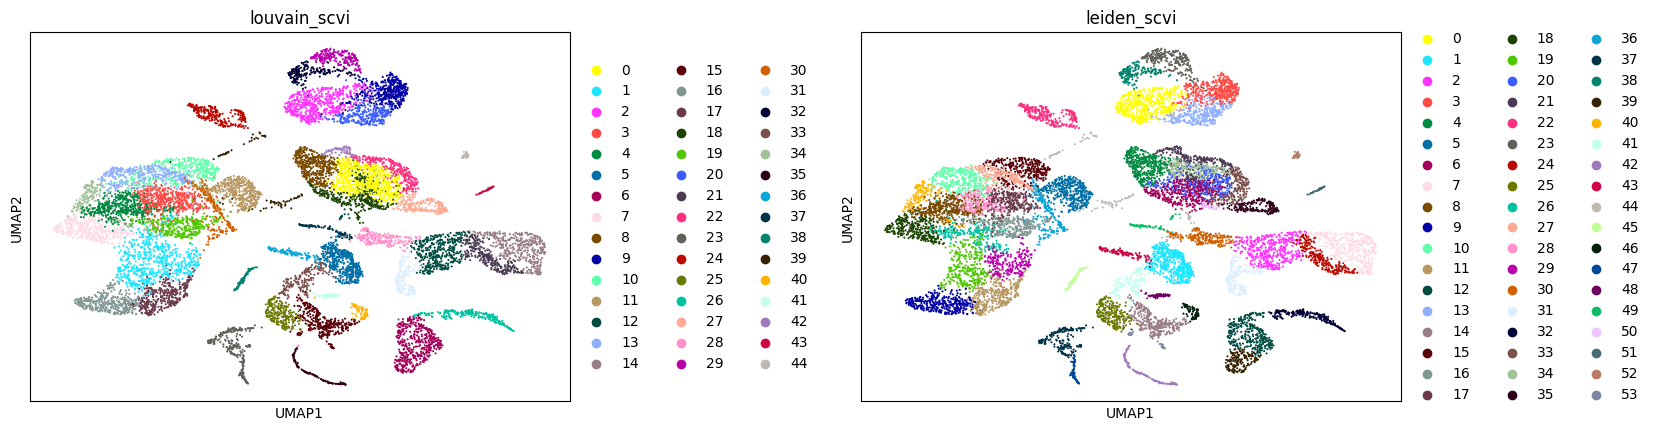

              ARI  Rand Index  Silhouette  Calinski-Harabasz
louvain  0.306747    0.915151    0.233284        2958.572510
leiden   0.259401    0.912924    0.247873        2879.324707


In [ ]:
df = get_clustering_metrics(adata_scvi,key='scvi',x1=2.2,x2=1)
print(df)

In [ ]:
def get_roc_markers(data,key):
    sc.tl.rank_genes_groups(
        data,
        groupby="cluster",
        method="logreg",
        key_added=f"rank_genes_logistic_{key}"
    )

    markers = list(
        sc.get.rank_genes_groups_df(
            data,
            group='ROCs',
            key=f"rank_genes_logistic_{key}"
        ).head(50)['names']
    )
    return markers

lst = [
    'wnt5a','loc100488523','loc100492954','egfl6','lpar3','cpa6','sp9','fgf9',
    'fbn2','tinagl1','fgf7','vwde','lef1','lamb2','fgfr4','fgf7','rspo2','cpa6',
    'loc100498358','krt','loc100486832','jag1','Xelaev18043128m','dlx2','tp73',
    'gdf6','Xelaev18046800m','nid2','igfbp2','ism2','dlx2','loc100493805','frem2',
    'Xelaev18044182m','bmp5','tspear','sema3f','robo4','jchain','rspo2','adamts18',
    'pltp','Xelaev18034799m','lamb1','lamb1','unc5b','mmp28','fgf10','pzp','galnt15'
]

markers_logistics_scvi = get_roc_markers(adata_scvi,"scvi")
#overlap_with_original = set(markers_logistics) & set([i.split('.')[0] for i in markers_logistics_scvi])
overlap_with_original = set([i.split('.')[0] for i in markers_logistics]) & set([i.split('.')[0] for i in markers_logistics_scvi])
overlap_with_reference = set(lst) & set([i.split('.')[0] for i in markers_logistics_scvi])

print(markers_logistics_scvi,len(markers_logistics_scvi))
print(len(overlap_with_original))
print(len(overlap_with_reference))

['apoc1.like.L', 'krt5.7.S', 'fn1.S', 'krt16.S', 'krt12.L', 'pltp.S', 'mdk.L', 'frem2.1.L', 's100a11.L', 'loc100490088.S', 'nid2.L', 'krt12.S', 'Xetrov90029035m.L', 'id3.S', 'ly6g6c.L', 'col1a1.S', 'col1a1.L', 'sparc.S', 'epcam.L', 'loc100490088.L', 'loc100486548.L', 'Xelaev18026267m.g', 'fras1.L', 'bambi.L', 'apoe.S', 'mdk.S', 'krt8.L', 'loc100127750.S', 'col14a1.S', 'col1a2.L', 'sparc.L', 'lum.L', 'id3.L', 'col14a1.L', 'optc.S', 'vwa2.S', 'epcam.S', 'Xelaev18022166m.g', 'lama5.L', 'lama1.L', 'plk2.S', 'krt.S', 'fstl1.L', 'loc100494515.like.L', 'krt18.L', 'ctsv.S', 'mmp3.L', 'egfl6.S', 'cpa6.L', 'mxra5.S'] 50
26
6


In [ ]:
import magic

adata_magic = adata.copy()
adata_magic = magic.MAGIC(solver="approximate").fit_transform(adata_magic)
print(adata.X.shape, adata_magic.X.shape)
# adata_magic.write("adata_denoised_magic.h5ad")

(13199, 26166) (13199, 26166)


44 60


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


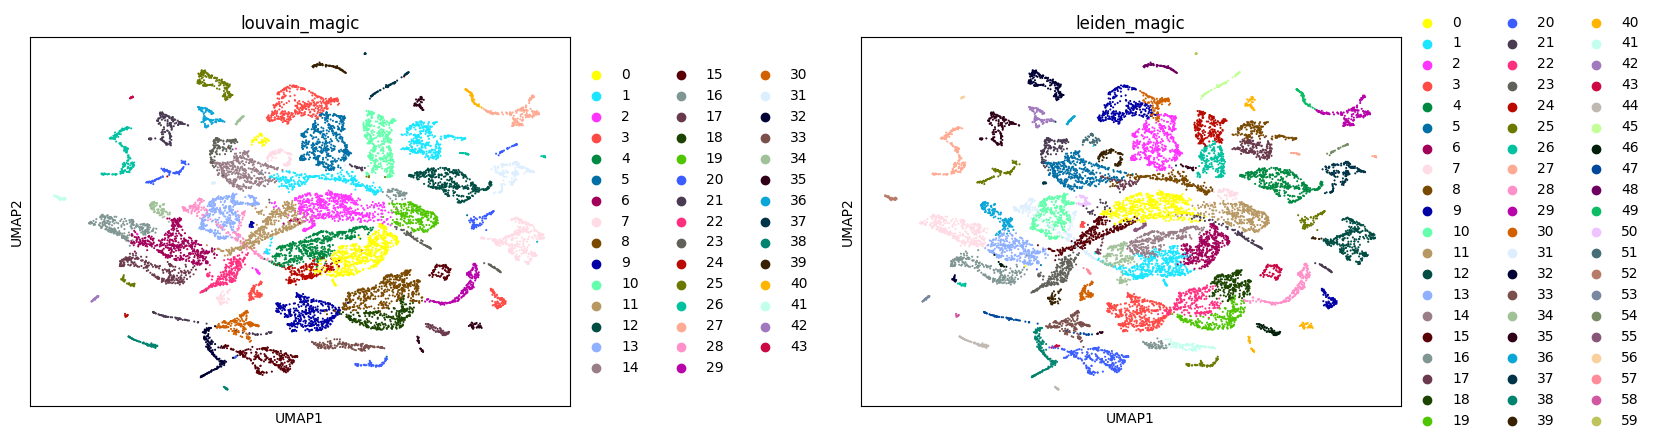

              ARI  Rand Index  Silhouette  Calinski-Harabasz
louvain  0.307659     0.91411    0.380053        5076.300781
leiden   0.245414     0.91098    0.368124        5146.776855


In [ ]:
df = get_clustering_metrics(adata_magic,key='magic',x1=1,x2=1)
print(df)

In [ ]:
def get_roc_markers(data,key):
    sc.tl.rank_genes_groups(
        data,
        groupby="cluster",
        method="logreg",
        key_added=f"rank_genes_logistic_{key}"
    )

    markers = list(
        sc.get.rank_genes_groups_df(
            data,
            group='ROCs',
            key=f"rank_genes_logistic_{key}"
        ).head(50)['names']
    )
    return markers

markers_logistics_magic = get_roc_markers(adata_magic,"magic")
overlap_with_original = set([i.split('.')[0] for i in markers_logistics]) & set([i.split('.')[0] for i in markers_logistics_magic])
overlap_with_reference = set(lst) & set([i.split('.')[0] for i in markers_logistics_magic])

print(markers_logistics_magic,len(markers_logistics_magic))
print(len(overlap_with_original))
print(len(overlap_with_reference))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['apoc1.like.L', 'fn1.S', 'krt5.7.S', 'Xetrov90029035m.L', 'bambi.L', 'krt16.S', 'nid2.L', 'pltp.S', 'frem2.1.L', 'loc100486548.L', 'hbd.L', 'col14a1.S', 'Xelaev18045096m.g', 'krt12.L', 'id3.S', 'Xelaev18045098m.g', 'hbd.S', 'Xelaev18045083m.g', 'krt8.L', 'fras1.L', 'Xelaev18045099m.g', 'Xelaev18045084m.g', 'loc100490088.S', 'ly6g6c.L', 'krt12.S', 'krt18.L', 'lama5.L', 'id3.L', 'mmp3.L', 'Xelaev18047464m.g', 'Xelaev18047455m.g', 'loc100490088.L', 'mdk.L', 'Xelaev18026267m.g', 'plk2.S', 'tmsb4x.L', 'optc.S', 'col14a1.L', 'azin2.S', 'mxra5.S', 'Xelaev18047460m.g', 'epcam.L', 'hes4.L', 'lama1.L', 'app.S', 'cpamd8.L', 'bambi.S', 'ctsv.S', 'krt.S', 'sparc.S'] 50
31
4


Batch intergration

In [3]:
!pip install harmonypy
!pip install bbknn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=5c1bacf942fcb8fbba902a582b93077e26aec1ee42138db6cd79de97cc078ef2
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [6]:
import harmonypy as hm
adata_harmony = adata.copy()

sc.tl.pca(adata_harmony, svd_solver='arpack')
adata_harmony.obs["batch"] = adata_harmony.obs["batch"].astype(str)
ho = hm.run_harmony(adata_harmony.obsm['X_pca'], adata_harmony.obs, 'batch')

adata_harmony.obsm['X_pca_harmony'] = ho.Z_corr.T
print(adata_harmony.obsm['X_pca_harmony'].shape)

# adata_harmony.write("adata_harmony.h5ad")

2025-10-07 00:39:35,183 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-07 00:39:47,079 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-07 00:39:47,321 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-07 00:39:55,443 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-07 00:40:02,328 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-07 00:40:07,996 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-10-07 00:40:18,713 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-10-07 00:40:29,564 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


(13199, 50)


In [7]:
import bbknn
adata_bbknn = adata.copy()
sc.tl.pca(adata_bbknn, svd_solver='arpack')
bbknn.bbknn(adata_bbknn, batch_key="batch")
sc.tl.umap(adata_bbknn)
print(adata_bbknn.obsp['connectivities'].shape)
# adata_bbknn.write("adata_bbknn.h5ad")


(13199, 13199)


In [8]:
def get_clustering_metrics_new(data, key='', use_rep=None,x1=1,x2=1):
    sc.pp.neighbors(data, use_rep=use_rep, n_neighbors=15)
    sc.tl.louvain(data, key_added=f"louvain_{key}",resolution=x1)
    sc.tl.leiden(data, key_added=f"leiden_{key}",resolution=x2)
    print(data.obs[f'louvain_{key}'].nunique(),data.obs[f'leiden_{key}'].nunique())

    sc.tl.umap(data)
    sc.pl.umap(data, color=[f"louvain_{key}", f"leiden_{key}"], wspace=0.4)

    true_labels = LabelEncoder().fit_transform(data.obs["cluster"].astype(str))

    results = {}
    for method in ["louvain", "leiden"]:
        pred_labels = data.obs[f"{method}_{key}"].astype(str)
        ari = adjusted_rand_score(true_labels, pred_labels)
        ri = rand_score(true_labels, pred_labels)
        sil = silhouette_score(data.obsm[use_rep], pred_labels)
        ch_score = calinski_harabasz_score(data.obsm[use_rep], pred_labels)
        results[method] = {
            "ARI": ari,
            "Rand Index": ri,
            "Silhouette": sil,
            "Calinski-Harabasz": ch_score,
        }

    df = pd.DataFrame(results).T
    return df


/tmp/ipython-input-2513037519.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data, key_added=f"leiden_{key}",resolution=x2)


45 46


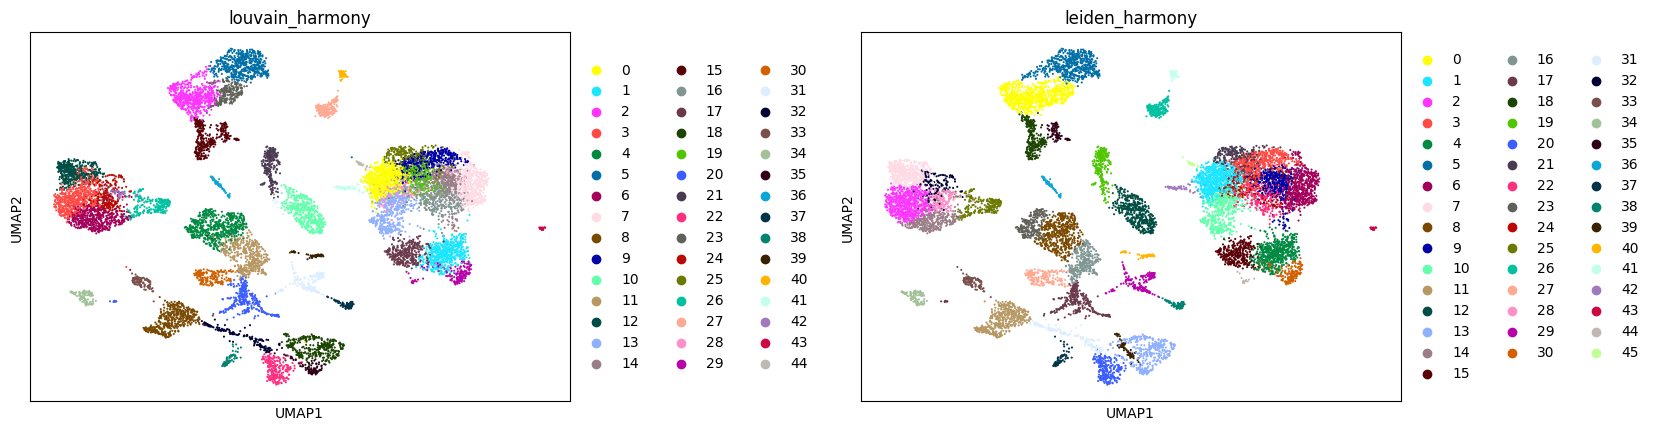

              ARI  Rand Index  Silhouette  Calinski-Harabasz
louvain  0.319465    0.915640    0.200454        2030.354370
leiden   0.338058    0.916976    0.201301        1964.062866


In [9]:
df = get_clustering_metrics_new(adata_harmony,key='harmony', use_rep='X_pca_harmony',x1=2.53,x2=2.15)
print(df)

46 46


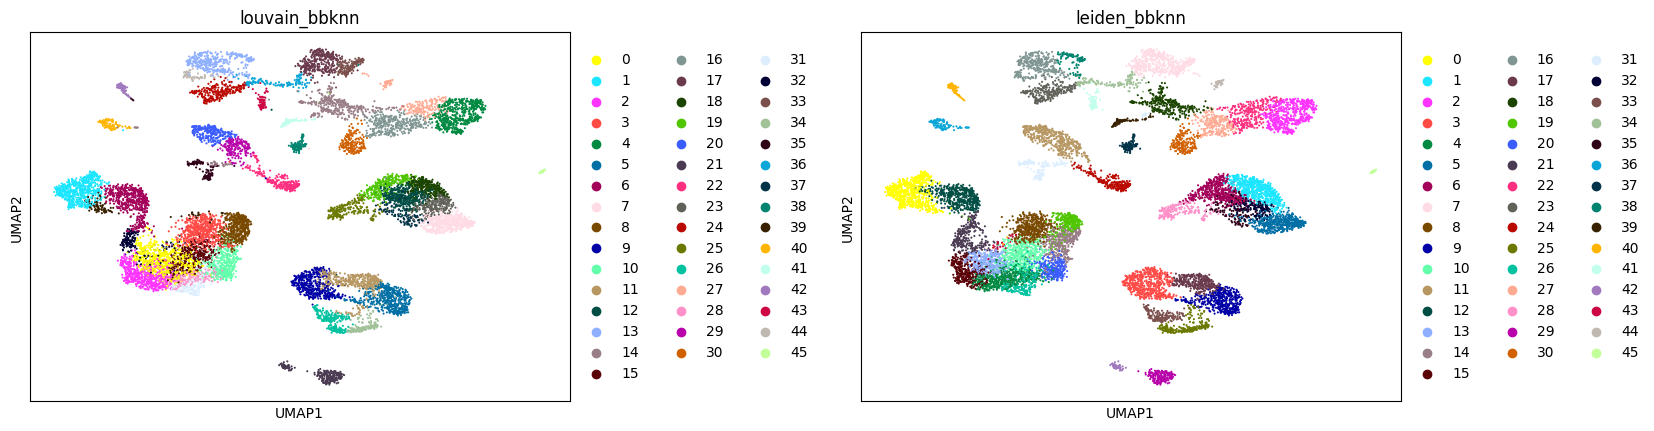

              ARI  Rand Index  Silhouette  Calinski-Harabasz
louvain  0.273116    0.911254    0.016785        1867.690308
leiden   0.293929    0.913642    0.018009        1973.777954


In [18]:
import numpy as np
def get_clustering_metrics_bbknn(data, key='', x1=1, x2=1):
    sc.tl.louvain(data, key_added=f"louvain_{key}", resolution=x1)
    sc.tl.leiden(data, key_added=f"leiden_{key}", resolution=x2)
    print(data.obs[f'louvain_{key}'].nunique(), data.obs[f'leiden_{key}'].nunique())

    sc.tl.umap(data)
    sc.pl.umap(data, color=[f"louvain_{key}", f"leiden_{key}"], wspace=0.4)

    true_labels = LabelEncoder().fit_transform(data.obs["cluster"].astype(str))

    # new distance matrixs
    connectivities = data.obsp['connectivities'].toarray()
    dist_matrix = 1 - connectivities
    np.fill_diagonal(dist_matrix, 0)

    results = {}
    for method in ["louvain", "leiden"]:
        pred_labels = data.obs[f"{method}_{key}"].astype(str)
        ari = adjusted_rand_score(true_labels, pred_labels)
        ri = rand_score(true_labels, pred_labels)

        # user precomputed distance
        sil = silhouette_score(dist_matrix, pred_labels, metric='precomputed')

        ch_score = calinski_harabasz_score(data.obsm['X_pca'], pred_labels)
        results[method] = {
            "ARI": ari,
            "Rand Index": ri,
            "Silhouette": sil,
            "Calinski-Harabasz": ch_score,
        }

    df = pd.DataFrame(results).T
    return df

df = get_clustering_metrics_bbknn(adata_bbknn, key='bbknn', x1=4.25, x2=2.9)
print(df)

In [ ]:
def get_roc_markers(data,key):
    sc.tl.rank_genes_groups(
        data,
        groupby="cluster",
        method="logreg",
        key_added=f"rank_genes_logistic_{key}"
    )

    markers = list(
        sc.get.rank_genes_groups_df(
            data,
            group='ROCs',
            key=f"rank_genes_logistic_{key}"
        ).head(50)['names']
    )
    return markers


markers_logistics_harmony = get_roc_markers(adata_harmony,"harmony")
overlap_with_original = set(markers_logistics) & set(markers_logistics_harmony) #set([i.split('.')[0] for i in markers_logistics_harmony])
overlap_with_reference = set(lst) & set([i.split('.')[0] for i in markers_logistics_harmony])

print(markers_logistics_harmony,len(markers_logistics_harmony))
print(len(overlap_with_original))
print(len(overlap_with_reference))

['apoc1.like.L', 'pltp.S', 'fn1.S', 'Xetrov90029035m.L', 'id3.L', 'frem2.1.L', 'nid2.L', 'loc100486548.L', 'fstl1.L', 'krt16.S', 'col14a1.S', 'sp9.L', 'loc100127750.S', 'ptgs1.S', 'krt5.7.S', 'lama5.L', 'fras1.L', 'hbd.L', 'mdk.L', 'egfl6.L', 'col14a1.L', 'Xelaev18045099m.g', 'id3.S', 'krt16.L', 'azin2.S', 'loc100490088.S', 'bmp4.S', 'Xelaev18045098m.g', 'sparc.S', 'plk2.S', 'lpar3.L', 'net1.L', 'krt12.L', 'lama1.L', 'mdk.S', 'app.S', 'Xelaev18045083m.g', 'bambi.L', 'loc100486548.S', 'ctsv.S', 'ifitm3.S', 'krt8.L', 'hbd.S', 'cpamd8.L', 'cldn6.1.S', 'tmsb4x.L', 'vwde.L', 'unc5b.L', 'optc.S', 'sparc.L'] 50
50
8


In [ ]:
markers_logistics_bbknn = get_roc_markers(adata_bbknn,"bbknn")
overlap_with_original = set(markers_logistics) & set(markers_logistics_bbknn)#set([i.split('.')[0] for i in markers_logistics_bbknn])
overlap_with_reference = set(lst) & set([i.split('.')[0] for i in markers_logistics_bbknn])

print(markers_logistics_bbknn,len(markers_logistics_bbknn))
print(len(overlap_with_original))
print(len(overlap_with_reference))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['apoc1.like.L', 'pltp.S', 'fn1.S', 'Xetrov90029035m.L', 'id3.L', 'frem2.1.L', 'nid2.L', 'loc100486548.L', 'fstl1.L', 'krt16.S', 'col14a1.S', 'sp9.L', 'loc100127750.S', 'ptgs1.S', 'krt5.7.S', 'lama5.L', 'fras1.L', 'hbd.L', 'mdk.L', 'egfl6.L', 'col14a1.L', 'Xelaev18045099m.g', 'id3.S', 'krt16.L', 'azin2.S', 'loc100490088.S', 'bmp4.S', 'Xelaev18045098m.g', 'sparc.S', 'plk2.S', 'lpar3.L', 'net1.L', 'krt12.L', 'lama1.L', 'mdk.S', 'app.S', 'Xelaev18045083m.g', 'bambi.L', 'loc100486548.S', 'ctsv.S', 'ifitm3.S', 'krt8.L', 'hbd.S', 'cpamd8.L', 'cldn6.1.S', 'tmsb4x.L', 'vwde.L', 'unc5b.L', 'optc.S', 'sparc.L'] 50
50
8
